In [ ]:
from google.colab import drive
drive.mount('/gdrive',force_remount=True)

Mounted at /gdrive


In [ ]:
# ============================================================
# PASO A — TABLA RESUMEN UNIFICADA (UNSW / CICIDS / KITSUNE)
#   - KS-test (numéricas)
#   - TSTR label (binario)
#   - TSTR attack_cat (multiclase)
#   - Muestreo por chunks + estratificado (anti-RAM)
#   - Export: summary_results.csv
# ============================================================

!pip install -q sdv packaging tqdm

import os, gc, time, math
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from collections import Counter

from scipy.stats import ks_2samp

import sklearn
print("scikit-learn:", sklearn.__version__)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix


# ===================== CONFIG GLOBAL =====================
RANDOM_STATE = 42

# para KS y TSTR trabajamos con muestras (anti-RAM)
REAL_SAMPLE_TARGET = 600_000
SYN_SAMPLE_TARGET  = 440_000   # UNSW tiene 440k; para CICIDS/KITSUNE ajusta si su SYN es menor
TEST_SIZE = 0.20

# chunks de lectura
CHUNK_SIZE_REAL = {
    "UNSW":   250_000,
    "CICIDS": 250_000,
    "KITSUNE":300_000,
}
CHUNK_SIZE_SYN = 200_000

# columnas objetivo
ATTACK_COL = "attack_cat"
LABEL_COL  = "label"

# KS: nº columnas a evaluar (si hay muchas)
KS_MAX_COLS = 10

# LR (saga) - para onehot sparse
LR_MAX_ITER = 200
LR_NJOBS = -1
# ========================================================


# ===================== PATHS (AJUSTA ESTO) =====================
DATASETS = [
    {
        "name": "UNSW",
        "REAL_PATH": "/gdrive/MyDrive/Datasets/UNSW_NB15_full_clean.csv",
        "SYN_PATH":  "/gdrive/MyDrive/Datasets/synthetic_UNSW_NB15_ctgan.csv",
    },
    {
        "name": "CICIDS",
        "REAL_PATH": "/gdrive/MyDrive/Datasets/MachineLearningCVE_full_clean.csv",
        "SYN_PATH":  "/gdrive/MyDrive/Datasets/synthetic_MachineLearningCVE_ctgan.csv",
    },
    {
        "name": "KITSUNE",
        "REAL_PATH": "/gdrive/MyDrive/Datasets/KITSUNE_full_clean.csv",
        "SYN_PATH":  "/gdrive/MyDrive/Datasets/synthetic_kitsune_ctgan.csv",
    },
]
# ===============================================================


def normalize_cols(cols):
    return [str(c).strip().replace(" ", "_").replace("/", "_").replace("-", "_").lower() for c in cols]


def safe_ohe():
    # sklearn >=1.2 usa sparse_output
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=True)


def enforce_cols_and_types(df: pd.DataFrame) -> pd.DataFrame:
    # normaliza columnas y fuerza presence
    df = df.copy()
    df.columns = normalize_cols(df.columns.tolist())

    if ATTACK_COL not in df.columns:
        raise ValueError(f"Falta '{ATTACK_COL}' en el dataframe.")
    if LABEL_COL not in df.columns:
        raise ValueError(f"Falta '{LABEL_COL}' en el dataframe.")

    df[ATTACK_COL] = df[ATTACK_COL].astype(str).str.strip()
    df[LABEL_COL]  = df[LABEL_COL].astype(str).str.strip()
    return df


def approx_line_count(path: str) -> int:
    with open(path, "rb") as f:
        return max(sum(1 for _ in f) - 1, 0)


def scan_attack_classes(path: str, chunksize: int, desc: str) -> Counter:
    cnt = Counter()
    reader = pd.read_csv(path, chunksize=chunksize, low_memory=False)
    for ch in tqdm(reader, desc=desc, unit="chunk"):
        ch.columns = normalize_cols(ch.columns.tolist())
        if ATTACK_COL not in ch.columns:
            raise ValueError(f"Falta {ATTACK_COL} en {path}")
        cnt.update(ch[ATTACK_COL].astype(str).str.strip().tolist())
        del ch
        gc.collect()
    return cnt


def stratified_sample_csv(
    path: str,
    target_n: int,
    chunksize: int,
    attack_cats_keep: list,
    normal_cap: int,
    per_attack_cap: int,
    seed: int,
    desc: str
) -> pd.DataFrame:
    """
    Muestra estratificada por attack_cat leyendo por chunks.
    - normal_cap: máximo nº de filas Normal
    - per_attack_cap: máximo nº por cada clase de ataque
    """
    rng = np.random.RandomState(seed)
    parts = []
    seen = Counter()

    reader = pd.read_csv(path, chunksize=chunksize, low_memory=False)
    for ch in tqdm(reader, desc=desc, unit="chunk"):
        ch.columns = normalize_cols(ch.columns.tolist())
        if ATTACK_COL not in ch.columns or LABEL_COL not in ch.columns:
            raise ValueError(f"Faltan columnas target en: {path}")

        # normaliza strings
        ch[ATTACK_COL] = ch[ATTACK_COL].astype(str).str.strip()
        ch[LABEL_COL]  = ch[LABEL_COL].astype(str).str.strip()

        # A) ataques
        for cat in attack_cats_keep:
            need = per_attack_cap - seen[cat]
            if need <= 0:
                continue
            sub = ch[ch[ATTACK_COL] == cat]
            if len(sub) == 0:
                continue
            take = min(need, len(sub))
            samp = sub.sample(n=take, random_state=int(rng.randint(0, 1e9)))
            parts.append(samp)
            seen[cat] += len(samp)

        # B) normal
        needN = normal_cap - seen["Normal"]
        if needN > 0:
            subN = ch[ch[ATTACK_COL].str.lower() == "normal"]
            if len(subN) > 0:
                takeN = min(needN, len(subN))
                sampN = subN.sample(n=takeN, random_state=int(rng.randint(0, 1e9)))
                parts.append(sampN)
                seen["Normal"] += len(sampN)

        del ch
        gc.collect()

        # corte temprano
        if sum(seen.values()) >= target_n:
            break

    if not parts:
        raise RuntimeError(f"No se pudo construir muestra estratificada: {path}")

    df = pd.concat(parts, ignore_index=True)
    df = df.sample(frac=1.0, random_state=seed).reset_index(drop=True)

    # recorte final si se pasó
    if len(df) > target_n:
        df = df.sample(n=target_n, random_state=seed).reset_index(drop=True)

    df = enforce_cols_and_types(df)
    return df


def ks_mean_abs(df_real: pd.DataFrame, df_syn: pd.DataFrame, max_cols=10, seed=42):
    # KS en columnas numéricas comunes (excluye targets)
    real = df_real.copy()
    syn  = df_syn.copy()

    num_real = set(real.select_dtypes(include=[np.number]).columns.tolist())
    num_syn  = set(syn.select_dtypes(include=[np.number]).columns.tolist())
    common = sorted(list((num_real & num_syn) - {LABEL_COL}))

    if not common:
        return np.nan, []

    rng = np.random.RandomState(seed)
    pick = common if len(common) <= max_cols else list(rng.choice(common, size=max_cols, replace=False))

    stats = []
    for c in pick:
        a = real[c].replace([np.inf, -np.inf], np.nan).dropna()
        b = syn[c].replace([np.inf, -np.inf], np.nan).dropna()
        if len(a) == 0 or len(b) == 0:
            continue
        ks, p = ks_2samp(a, b)
        stats.append((c, float(ks), float(p)))

    if not stats:
        return np.nan, []

    mean_abs = float(np.mean([abs(x[1]) for x in stats]))
    return mean_abs, stats


def build_preprocessor(X_all: pd.DataFrame):
    # separa cat/num
    cat_cols = [c for c in X_all.columns if X_all[c].dtype == object]
    num_cols = [c for c in X_all.columns if c not in cat_cols]

    ohe = safe_ohe()
    pre = ColumnTransformer(
        transformers=[
            ("cat", ohe, cat_cols),
            ("num", "passthrough", num_cols),
        ],
        remainder="drop",
        sparse_threshold=1.0,
    )
    return pre, cat_cols, num_cols


def tstr_lr(df_real: pd.DataFrame, df_syn: pd.DataFrame, target: str):
    """
    Train en SYN, test en REAL.
    OneHot sparse + LogisticRegression(saga)
    """
    # features comunes
    drop_cols = [LABEL_COL, ATTACK_COL]
    Xr = df_real.drop(columns=[c for c in drop_cols if c in df_real.columns], errors="ignore").copy()
    Xs = df_syn.drop(columns=[c for c in drop_cols if c in df_syn.columns], errors="ignore").copy()

    common_cols = [c for c in Xr.columns if c in Xs.columns]
    if not common_cols:
        return {"ok": False, "err": "No hay columnas comunes X entre REAL y SYN."}

    Xr = Xr[common_cols].copy()
    Xs = Xs[common_cols].copy()

    # limpia object/nans
    for c in common_cols:
        if Xr[c].dtype == object or Xs[c].dtype == object:
            Xr[c] = Xr[c].astype(str).fillna("__NA__")
            Xs[c] = Xs[c].astype(str).fillna("__NA__")
        else:
            Xr[c] = pd.to_numeric(Xr[c], errors="coerce").fillna(0)
            Xs[c] = pd.to_numeric(Xs[c], errors="coerce").fillna(0)

    y_real = df_real[target].astype(str).str.strip()
    y_syn  = df_syn[target].astype(str).str.strip()

    # preprocessor fit con ambos
    X_all = pd.concat([Xr, Xs], axis=0, ignore_index=True)
    pre, cat_cols, num_cols = build_preprocessor(X_all)

    t0 = time.time()
    pre.fit(X_all)
    Xr_enc = pre.transform(Xr)
    Xs_enc = pre.transform(Xs)
    t_pre = time.time() - t0

    # split REAL para test (solo para evaluar)
    # (train siempre SYN completo)
    Xr_tr, Xr_te, yr_tr, yr_te = train_test_split(
        Xr_enc, y_real, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_real if y_real.nunique() > 1 else None
    )

    # entreno en SYN
    clf = LogisticRegression(
        solver="saga",
        max_iter=LR_MAX_ITER,
        n_jobs=LR_NJOBS,
        multi_class="auto",
    )

    t1 = time.time()
    clf.fit(Xs_enc, y_syn)
    t_fit = time.time() - t1

    yp = clf.predict(Xr_te)

    acc = float(accuracy_score(yr_te, yp))
    f1w = float(f1_score(yr_te, yp, average="weighted"))
    f1m = float(f1_score(yr_te, yp, average="macro"))

    n_features = int(getattr(Xr_enc, "shape", [None, None])[1])

    return {
        "ok": True,
        "acc": acc,
        "f1w": f1w,
        "f1m": f1m,
        "fit_s": float(t_fit),
        "prep_s": float(t_pre),
        "n_features_ohe": n_features,
        "cat_cols": len(cat_cols),
        "num_cols": len(num_cols),
    }


rows = []

for ds in DATASETS:
    name = ds["name"]
    real_path = ds["REAL_PATH"]
    syn_path  = ds["SYN_PATH"]

    print("\n" + "="*80)
    print(f"[DATASET] {name}")
    print(f"[PATH REAL] {real_path}")
    print(f"[PATH SYN ] {syn_path}")

    # --------- scan clases (REAL y SYN) ---------
    real_lines = approx_line_count(real_path)
    real_chunks = max(1, int(math.ceil(real_lines / CHUNK_SIZE_REAL[name])))
    print(f"[INFO] REAL filas aprox: {real_lines:,} | chunks: {real_chunks}")

    print("[INFO] Scan clases REAL...")
    cnt_real = scan_attack_classes(real_path, CHUNK_SIZE_REAL[name], desc=f"{name} Scan REAL")
    attack_real = sorted([c for c in cnt_real.keys() if str(c).strip().lower() != "normal"])

    syn_lines = approx_line_count(syn_path)
    syn_chunks = max(1, int(math.ceil(syn_lines / CHUNK_SIZE_SYN)))
    print(f"[INFO] SYN filas aprox: {syn_lines:,} | chunks: {syn_chunks}")

    print("[INFO] Scan clases SYN...")
    cnt_syn = scan_attack_classes(syn_path, CHUNK_SIZE_SYN, desc=f"{name} Scan SYN")
    attack_syn = sorted([c for c in cnt_syn.keys() if str(c).strip().lower() != "normal"])

    common_attack = sorted(list(set(attack_real) & set(attack_syn)))

    print("[INFO] attack REAL (sin Normal):", attack_real)
    print("[INFO] attack SYN  (sin Normal):", attack_syn)
    print("[INFO] attack comunes:", common_attack)

    # --------- construir muestras estratificadas ---------
    # estrategia: equilibrar para no quedarnos en "todo Normal"
    # Normal: ~250k (si hay), ataques: repartir el resto
    normal_cap_real = min(250_000, REAL_SAMPLE_TARGET)
    normal_cap_syn  = min(200_000, SYN_SAMPLE_TARGET)  # típico en tus sintéticos

    # repartir ataques
    kR = max(1, len(common_attack))
    per_attack_real = int(max(5_000, (REAL_SAMPLE_TARGET - normal_cap_real) / kR))
    per_attack_syn  = int(max(5_000, (SYN_SAMPLE_TARGET  - normal_cap_syn ) / kR))

    print("[INFO] Muestreo REAL estratificado...")
    df_real = stratified_sample_csv(
        real_path,
        target_n=REAL_SAMPLE_TARGET,
        chunksize=CHUNK_SIZE_REAL[name],
        attack_cats_keep=common_attack,
        normal_cap=normal_cap_real,
        per_attack_cap=per_attack_real,
        seed=RANDOM_STATE,
        desc=f"{name} REAL sample"
    )

    print("[INFO] Muestreo SYN estratificado...")
    df_syn = stratified_sample_csv(
        syn_path,
        target_n=min(SYN_SAMPLE_TARGET, syn_lines),
        chunksize=CHUNK_SIZE_SYN,
        attack_cats_keep=common_attack,
        normal_cap=normal_cap_syn,
        per_attack_cap=per_attack_syn,
        seed=RANDOM_STATE,
        desc=f"{name} SYN sample"
    )

    print(f"[OK] REAL sample: {df_real.shape} | SYN sample: {df_syn.shape}")

    # --------- distros rápidas ---------
    real_attack_top = df_real[ATTACK_COL].value_counts().head(10).to_dict()
    syn_attack_top  = df_syn[ATTACK_COL].value_counts().head(10).to_dict()
    real_label_dist = df_real[LABEL_COL].value_counts().to_dict()
    syn_label_dist  = df_syn[LABEL_COL].value_counts().to_dict()

    # --------- KS ---------
    ks_mean, ks_stats = ks_mean_abs(df_real, df_syn, max_cols=KS_MAX_COLS, seed=RANDOM_STATE)

    # --------- TSTR label ---------
    print("[INFO] TSTR -> label (binario)")
    tstr_label = tstr_lr(df_real, df_syn, target=LABEL_COL)

    # --------- TSTR multiclase (si >1 clase en REAL sample) ---------
    # (si solo hay Normal en REAL sample, no lo calculamos)
    tstr_multi = {"ok": False}
    if df_real[ATTACK_COL].nunique() > 1 and df_syn[ATTACK_COL].nunique() > 1:
        print("[INFO] TSTR -> attack_cat (multiclase)")
        tstr_multi = tstr_lr(df_real, df_syn, target=ATTACK_COL)
    else:
        tstr_multi = {"ok": False, "err": "REAL o SYN no tienen multiclase en la muestra."}

    row = {
        "dataset": name,
        "real_rows_sample": int(df_real.shape[0]),
        "syn_rows_sample": int(df_syn.shape[0]),
        "real_attack_classes": int(df_real[ATTACK_COL].nunique()),
        "syn_attack_classes": int(df_syn[ATTACK_COL].nunique()),
        "real_attack_top": str(real_attack_top),
        "syn_attack_top": str(syn_attack_top),
        "real_label_dist": str({str(k): int(v) for k, v in real_label_dist.items()}),
        "syn_label_dist": str({str(k): int(v) for k, v in syn_label_dist.items()}),
        "ks_mean_abs": float(ks_mean) if ks_mean == ks_mean else np.nan,
        "ks_cols": str([(c, ks) for (c, ks, p) in ks_stats]),
        # TSTR label
        "tstr_label_ok": bool(tstr_label.get("ok", False)),
        "tstr_label_acc": float(tstr_label.get("acc", np.nan)),
        "tstr_label_f1w": float(tstr_label.get("f1w", np.nan)),
        "tstr_label_f1m": float(tstr_label.get("f1m", np.nan)),
        "tstr_label_fit_s": float(tstr_label.get("fit_s", np.nan)),
        # TSTR multi
        "tstr_multi_ok": bool(tstr_multi.get("ok", False)),
        "tstr_multi_acc": float(tstr_multi.get("acc", np.nan)),
        "tstr_multi_f1w": float(tstr_multi.get("f1w", np.nan)),
        "tstr_multi_f1m": float(tstr_multi.get("f1m", np.nan)),
        "tstr_multi_fit_s": float(tstr_multi.get("fit_s", np.nan)),
        # features
        "n_features_ohe": int(tstr_label.get("n_features_ohe", tstr_multi.get("n_features_ohe", np.nan))) if (tstr_label.get("ok", False) or tstr_multi.get("ok", False)) else np.nan,
    }

    rows.append(row)

    del df_real, df_syn
    gc.collect()

# --------- tabla final ---------
summary = pd.DataFrame(rows)
print("\n" + "="*80)
print("TABLA RESUMEN (Paso A)")
display(summary)

out_path = "/gdrive/MyDrive/Datasets/summary_results.csv"
summary.to_csv(out_path, index=False, encoding="utf-8")
print(f"\n[OK] Guardado: {out_path}")


scikit-learn: 1.6.1

[DATASET] UNSW
[PATH REAL] /gdrive/MyDrive/Datasets/UNSW_NB15_full_clean.csv
[PATH SYN ] /gdrive/MyDrive/Datasets/synthetic_UNSW_NB15_ctgan.csv
[INFO] REAL filas aprox: 2,540,047 | chunks: 11
[INFO] Scan clases REAL...


UNSW Scan REAL: 0chunk [00:00, ?chunk/s]

[INFO] SYN filas aprox: 440,000 | chunks: 3
[INFO] Scan clases SYN...


UNSW Scan SYN: 0chunk [00:00, ?chunk/s]

[INFO] attack REAL (sin Normal): ['Analysis', 'Backdoors', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode']
[INFO] attack SYN  (sin Normal): ['Analysis', 'Backdoors', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode']
[INFO] attack comunes: ['Analysis', 'Backdoors', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode']
[INFO] Muestreo REAL estratificado...


UNSW REAL sample: 0chunk [00:00, ?chunk/s]

[INFO] Muestreo SYN estratificado...


UNSW SYN sample: 0chunk [00:00, ?chunk/s]

[OK] REAL sample: (396808, 45) | SYN sample: (440000, 45)
[INFO] TSTR -> label (binario)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[INFO] TSTR -> attack_cat (multiclase)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



[DATASET] CICIDS
[PATH REAL] /gdrive/MyDrive/Datasets/MachineLearningCVE_full_clean.csv
[PATH SYN ] /gdrive/MyDrive/Datasets/synthetic_MachineLearningCVE_ctgan.csv
[INFO] REAL filas aprox: 2,830,743 | chunks: 12
[INFO] Scan clases REAL...


CICIDS Scan REAL: 0chunk [00:00, ?chunk/s]

[INFO] SYN filas aprox: 290,000 | chunks: 2
[INFO] Scan clases SYN...


CICIDS Scan SYN: 0chunk [00:00, ?chunk/s]

[INFO] attack REAL (sin Normal): ['DDoS', 'Generic', 'PortScan']
[INFO] attack SYN  (sin Normal): ['DDoS', 'Generic', 'PortScan']
[INFO] attack comunes: ['DDoS', 'Generic', 'PortScan']
[INFO] Muestreo REAL estratificado...


CICIDS REAL sample: 0chunk [00:00, ?chunk/s]

[INFO] Muestreo SYN estratificado...


CICIDS SYN sample: 0chunk [00:00, ?chunk/s]

[OK] REAL sample: (599998, 80) | SYN sample: (290000, 80)
[INFO] TSTR -> label (binario)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[INFO] TSTR -> attack_cat (multiclase)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



[DATASET] KITSUNE
[PATH REAL] /gdrive/MyDrive/Datasets/KITSUNE_full_clean.csv
[PATH SYN ] /gdrive/MyDrive/Datasets/synthetic_kitsune_ctgan.csv
[INFO] REAL filas aprox: 20,438,941 | chunks: 69
[INFO] Scan clases REAL...


KITSUNE Scan REAL: 0chunk [00:00, ?chunk/s]

[INFO] SYN filas aprox: 380,000 | chunks: 2
[INFO] Scan clases SYN...


KITSUNE Scan SYN: 0chunk [00:00, ?chunk/s]

[INFO] attack REAL (sin Normal): ['DDoS', 'DoS', 'Fuzzers', 'Generic', 'MitM', 'Reconnaissance']
[INFO] attack SYN  (sin Normal): ['DDoS', 'DoS', 'Fuzzers', 'Generic', 'MitM', 'Reconnaissance']
[INFO] attack comunes: ['DDoS', 'DoS', 'Fuzzers', 'Generic', 'MitM', 'Reconnaissance']
[INFO] Muestreo REAL estratificado...


KITSUNE REAL sample: 0chunk [00:00, ?chunk/s]

[INFO] Muestreo SYN estratificado...


KITSUNE SYN sample: 0chunk [00:00, ?chunk/s]

[OK] REAL sample: (599998, 7) | SYN sample: (380000, 7)
[INFO] TSTR -> label (binario)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[INFO] TSTR -> attack_cat (multiclase)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



TABLA RESUMEN (Paso A)


,dataset,real_rows_sample,syn_rows_sample,real_attack_classes,syn_attack_classes,real_attack_top,syn_attack_top,real_label_dist,syn_label_dist,ks_mean_abs,...,tstr_label_acc,tstr_label_f1w,tstr_label_f1m,tstr_label_fit_s,tstr_multi_ok,tstr_multi_acc,tstr_multi_f1w,tstr_multi_f1m,tstr_multi_fit_s,n_features_ohe
0,UNSW,396808,440000,9,9,"{'Normal': 250000, 'Generic': 43750, 'Exploits...","{'Normal': 200000, 'DoS': 30000, 'Generic': 30...","{'0': 250000, '1': 146808}","{'1': 240000, '0': 200000}",0.436338,...,0.369043,0.202374,0.271639,109.262295,True,0.031249,0.005796,0.012118,205.315048,317
1,CICIDS,599998,290000,4,4,"{'Normal': 250000, 'DDoS': 116666, 'PortScan':...","{'Normal': 200000, 'DDoS': 30000, 'Generic': 3...","{'1': 349998, '0': 250000}","{'0': 200000, '1': 90000}",0.480086,...,0.485083,0.446678,0.464275,129.753283,True,0.477033,0.362392,0.297078,173.677460,78
2,KITSUNE,599998,380000,7,7,"{'Normal': 250000, 'Fuzzers': 58333, 'DDoS': 5...","{'Normal': 200000, 'DoS': 30000, 'Generic': 30...","{'1': 349998, '0': 250000}","{'0': 200000, '1': 180000}",0.407913,...,0.416667,0.245098,0.294118,51.924217,True,0.416667,0.245098,0.084034,73.951527,92



[OK] Guardado: /gdrive/MyDrive/Datasets/summary_results.csv


[OK] Guardaré figuras en: /gdrive/MyDrive/MasterIA/Imagenes
[OK] Guardado: /gdrive/MyDrive/MasterIA/Imagenes/Figura_3_1_flujo_metodologico.png


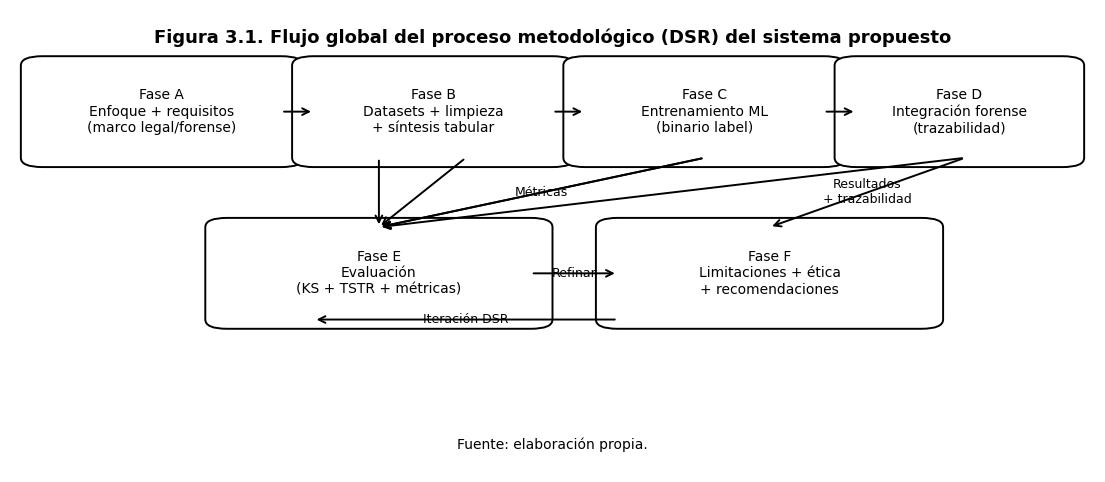

[OK] Guardado: /gdrive/MyDrive/MasterIA/Imagenes/Figura_3_2_control_tamano_sintetico.png


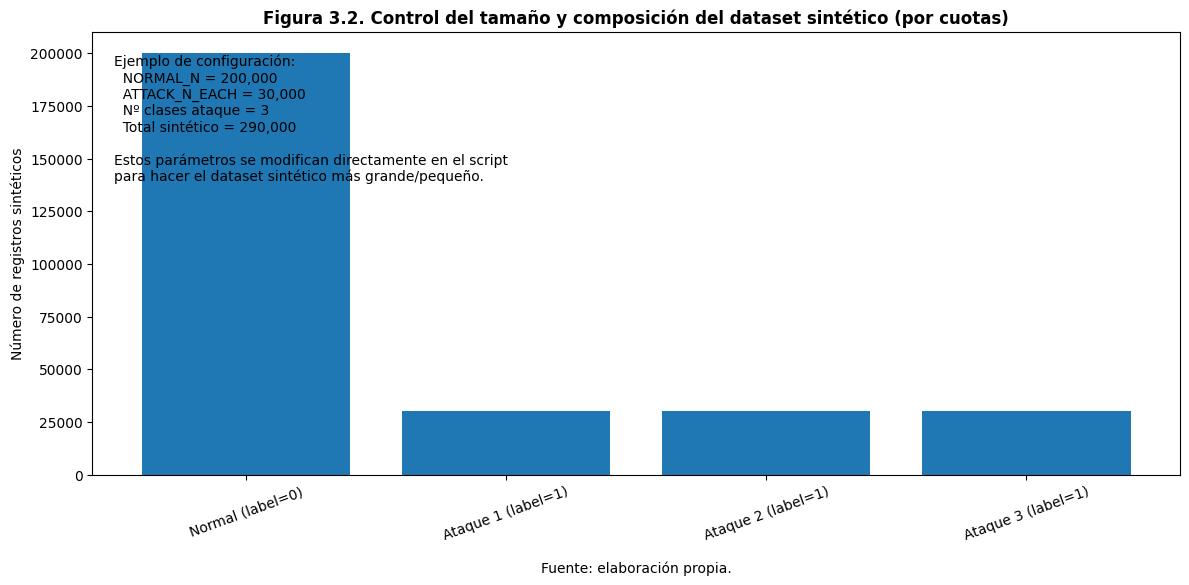

[OK] Guardado: /gdrive/MyDrive/MasterIA/Imagenes/Figura_3_3_pipeline_shap.png


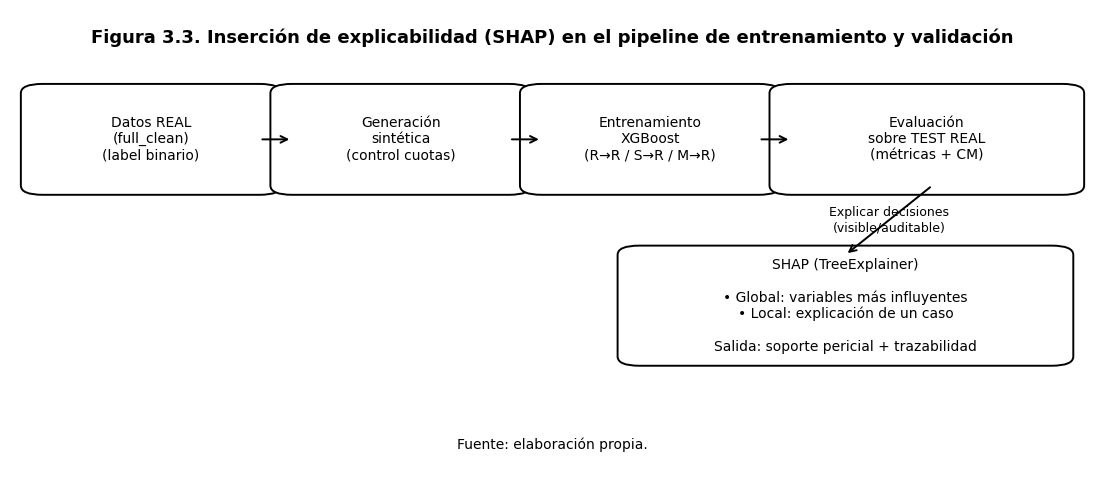


[FIN] Figuras Capítulo 3 generadas.


In [ ]:
# ===================== FIGURAS CAPÍTULO 3 (Python) =====================
# Figura 3.1: Flujo metodológico global (DSR A–F)
# Figura 3.2: Control del tamaño/composición del dataset sintético (parámetros)
# Figura 3.3: Inserción de SHAP/XAI en el pipeline (sobre test REAL)
#
# Salida: 3 PNG guardados (por defecto en Drive si existe, si no en /content)

import os
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import textwrap

# --------------------- CONFIG RUTA SALIDA ---------------------
OUT_DIR = "/gdrive/MyDrive/MasterIA/Imagenes"
if not os.path.exists("/gdrive/MyDrive/MasterIA/Imagenes"):
    OUT_DIR = "/content/TFM_figuras"

os.makedirs(OUT_DIR, exist_ok=True)
print("[OK] Guardaré figuras en:", OUT_DIR)

# --------------------- HELPERS ---------------------
def add_box(ax, xy, w, h, text, fontsize=10, pad=0.02):
    """Caja redondeada con texto centrado."""
    box = FancyBboxPatch(
        xy, w, h,
        boxstyle=f"round,pad={pad}",
        linewidth=1.4,
        facecolor="white",
        edgecolor="black"
    )
    ax.add_patch(box)
    ax.text(xy[0] + w/2, xy[1] + h/2, text, ha="center", va="center", fontsize=fontsize)
    return box

def add_arrow(ax, start, end, text=None, fontsize=9):
    """Flecha entre dos puntos."""
    arrow = FancyArrowPatch(start, end, arrowstyle="->", mutation_scale=12, linewidth=1.4, color="black")
    ax.add_patch(arrow)
    if text:
        mx = (start[0] + end[0]) / 2
        my = (start[1] + end[1]) / 2
        ax.text(mx, my, text, ha="center", va="center", fontsize=fontsize)
    return arrow

def save_fig(fig, filename):
    path = os.path.join(OUT_DIR, filename)
    fig.savefig(path, dpi=220, bbox_inches="tight")
    print("[OK] Guardado:", path)
    return path

# ===================== FIGURA 3.1 =====================
# Flujo global (A–F)
fig, ax = plt.subplots(figsize=(14, 6))
ax.set_axis_off()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

title = "Figura 3.1. Flujo global del proceso metodológico (DSR) del sistema propuesto"
ax.text(0.5, 0.96, title, ha="center", va="top", fontsize=13, fontweight="bold")

# Cajas principales (6 fases)
boxes = [
    ("Fase A\nEnfoque + requisitos\n(marco legal/forense)", (0.03, 0.68), 0.22, 0.20),
    ("Fase B\nDatasets + limpieza\n+ síntesis tabular",     (0.28, 0.68), 0.22, 0.20),
    ("Fase C\nEntrenamiento ML\n(binario label)",          (0.53, 0.68), 0.22, 0.20),
    ("Fase D\nIntegración forense\n(trazabilidad)",        (0.78, 0.68), 0.19, 0.20),
    ("Fase E\nEvaluación\n(KS + TSTR + métricas)",         (0.20, 0.33), 0.28, 0.20),
    ("Fase F\nLimitaciones + ética\n+ recomendaciones",    (0.56, 0.33), 0.28, 0.20),
]
for txt, xy, w, h in boxes:
    add_box(ax, xy, w, h, txt, fontsize=10)

# Flechas
add_arrow(ax, (0.25, 0.78), (0.28, 0.78))
add_arrow(ax, (0.50, 0.78), (0.53, 0.78))
add_arrow(ax, (0.75, 0.78), (0.78, 0.78))
add_arrow(ax, (0.88, 0.68), (0.70, 0.53), text="Resultados\n+ trazabilidad", fontsize=9)
add_arrow(ax, (0.42, 0.68), (0.34, 0.53))
add_arrow(ax, (0.34, 0.53), (0.34, 0.53))  # ancla visual

# Conexión hacia evaluación (E) y cierre (F)
add_arrow(ax, (0.64, 0.68), (0.34, 0.53), text="Métricas", fontsize=9)
add_arrow(ax, (0.34, 0.53), (0.34, 0.53))
add_arrow(ax, (0.34, 0.53), (0.34, 0.53))
add_arrow(ax, (0.34, 0.53), (0.34, 0.53))

add_arrow(ax, (0.34, 0.68), (0.34, 0.53))  # B->E
add_arrow(ax, (0.64, 0.68), (0.34, 0.53))  # C->E
add_arrow(ax, (0.88, 0.68), (0.34, 0.53))  # D->E
add_arrow(ax, (0.48, 0.43), (0.56, 0.43), text="Refinar", fontsize=9)  # E->F
add_arrow(ax, (0.56, 0.33), (0.28, 0.33), text="Iteración DSR", fontsize=9)  # F->E

ax.text(0.5, 0.06, "Fuente: elaboración propia.", ha="center", va="center", fontsize=10)
save_fig(fig, "Figura_3_1_flujo_metodologico.png")
plt.show()

# ===================== FIGURA 3.2 =====================
# Control de tamaño y composición sintética (parámetros)
fig, ax = plt.subplots(figsize=(12, 6))

# Ejemplo didáctico: puedes ajustar estos valores para que coincidan con tu caso real
NORMAL_N = 200_000
ATTACK_EACH = 30_000
N_ATTACK_CLASSES = 3  # CICIDS (DDoS, Generic, PortScan) en tu caso real

syn_total = NORMAL_N + ATTACK_EACH * N_ATTACK_CLASSES
labels = ["Normal (label=0)"] + [f"Ataque {i+1} (label=1)" for i in range(N_ATTACK_CLASSES)]
values = [NORMAL_N] + [ATTACK_EACH]*N_ATTACK_CLASSES

ax.bar(labels, values)
ax.set_title("Figura 3.2. Control del tamaño y composición del dataset sintético (por cuotas)", fontweight="bold")
ax.set_ylabel("Número de registros sintéticos")
ax.tick_params(axis='x', rotation=20)

# Texto explicativo dentro del gráfico
txt = (
    f"Ejemplo de configuración:\n"
    f"  NORMAL_N = {NORMAL_N:,}\n"
    f"  ATTACK_N_EACH = {ATTACK_EACH:,}\n"
    f"  Nº clases ataque = {N_ATTACK_CLASSES}\n"
    f"  Total sintético = {syn_total:,}\n\n"
    f"Estos parámetros se modifican directamente en el script\npara hacer el dataset sintético más grande/pequeño."
)
ax.text(0.02, 0.95, txt, transform=ax.transAxes, va="top", fontsize=10)

ax.text(0.5, -0.22, "Fuente: elaboración propia.", transform=ax.transAxes, ha="center", fontsize=10)
plt.tight_layout()
save_fig(fig, "Figura_3_2_control_tamano_sintetico.png")
plt.show()

# ===================== FIGURA 3.3 =====================
# Inserción de SHAP en el pipeline (sobre test REAL)
fig, ax = plt.subplots(figsize=(14, 6))
ax.set_axis_off()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.text(0.5, 0.96, "Figura 3.3. Inserción de explicabilidad (SHAP) en el pipeline de entrenamiento y validación",
        ha="center", va="top", fontsize=13, fontweight="bold")

# Pipeline lineal con SHAP sobre test real
b1 = add_box(ax, (0.03, 0.62), 0.20, 0.20, "Datos REAL\n(full_clean)\n(label binario)", fontsize=10)
b2 = add_box(ax, (0.26, 0.62), 0.20, 0.20, "Generación\nsintética\n(control cuotas)", fontsize=10)
b3 = add_box(ax, (0.49, 0.62), 0.20, 0.20, "Entrenamiento\nXGBoost\n(R→R / S→R / M→R)", fontsize=10)
b4 = add_box(ax, (0.72, 0.62), 0.25, 0.20, "Evaluación\nsobre TEST REAL\n(métricas + CM)", fontsize=10)

# SHAP (bloque inferior conectado a test real)
b5 = add_box(ax, (0.58, 0.25), 0.38, 0.22,
             "SHAP (TreeExplainer)\n\n• Global: variables más influyentes\n• Local: explicación de un caso\n\nSalida: soporte pericial + trazabilidad",
             fontsize=10)

# Flechas principales
add_arrow(ax, (0.23, 0.72), (0.26, 0.72))
add_arrow(ax, (0.46, 0.72), (0.49, 0.72))
add_arrow(ax, (0.69, 0.72), (0.72, 0.72))

# Flecha de evaluación a SHAP
add_arrow(ax, (0.85, 0.62), (0.77, 0.47), text="Explicar decisiones\n(visible/auditable)", fontsize=9)

ax.text(0.5, 0.06, "Fuente: elaboración propia.", ha="center", va="center", fontsize=10)
save_fig(fig, "Figura_3_3_pipeline_shap.png")
plt.show()

print("\n[FIN] Figuras Capítulo 3 generadas.")


In [ ]:
# ===================== GENERADOR FIGURAS + TABLAS CAPÍTULO 3 (TFM) =====================
# Crea PNG listos para Word (figuras y tablas).
# No requiere cargar datasets (solo valores/resumen).
# -------------------------------------------------------------------------------------

!pip -q install matplotlib pandas

import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, ArrowStyle
from matplotlib.patches import FancyArrowPatch

# -------------------- Carpetas de salida --------------------
BASE_DIR = "/gdrive/MyDrive/MasterIA/Imagenes/Capitulo3"
FIG_DIR  = os.path.join(BASE_DIR, "figures")
TAB_DIR  = os.path.join(BASE_DIR, "tables")
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)

def save_fig(path, dpi=300):
    plt.tight_layout()
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    plt.close()

def draw_box(ax, x, y, w, h, text, fontsize=10):
    box = FancyBboxPatch((x, y), w, h, boxstyle="round,pad=0.02,rounding_size=0.02",
                         linewidth=1.2, edgecolor="black", facecolor="white")
    ax.add_patch(box)
    ax.text(x + w/2, y + h/2, text, ha="center", va="center", fontsize=fontsize)

def draw_arrow(ax, x1, y1, x2, y2):
    arr = FancyArrowPatch((x1, y1), (x2, y2),
                          arrowstyle=ArrowStyle("->", head_length=6, head_width=3),
                          linewidth=1.2, color="black")
    ax.add_patch(arr)

def df_to_table_png(df, out_png, title=None, font_size=9, scale=(1, 1.25)):
    """Renderiza un DataFrame a PNG (tabla) usando matplotlib."""
    fig, ax = plt.subplots(figsize=(12, max(2.5, 0.45 * len(df) + 1)))
    ax.axis("off")
    if title:
        ax.set_title(title, fontsize=12, pad=10)
    tbl = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(font_size)
    tbl.scale(*scale)
    save_fig(out_png)

# ===================== DATOS RESUMEN (según tus ejecuciones) =====================
# Puedes ajustar estos valores si cambian, pero son los que has reportado.

datasets_summary = pd.DataFrame([
    {
        "Dataset": "CICIDS2017 (MachineLearningCVE)",
        "Filas reales aprox.": "2,830,743",
        "Nº variables": 80,
        "Clases attack_cat": "Normal, DDoS, PortScan, Generic",
        "Uso en TFM": "Principal (binario label + XAI)",
        "Observación": "Estable y rico en variables"
    },
    {
        "Dataset": "UNSW-NB15",
        "Filas reales aprox.": "2,540,047",
        "Nº variables": 45,
        "Clases attack_cat": "Normal + 8 ataques (Analysis, Backdoors, ...)",
        "Uso en TFM": "Comparación breve",
        "Observación": "Muchas clases minoritarias"
    },
    {
        "Dataset": "Kitsune (IoT)",
        "Filas reales aprox.": "20,438,941",
        "Nº variables": 7,
        "Clases attack_cat": "Normal + 6 ataques (DDoS, DoS, ...)",
        "Uso en TFM": "Comparación breve",
        "Observación": "Pocas variables; muy grande"
    }
])

rule_table = pd.DataFrame([
    {"attack_cat": "Normal", "label": 0},
    {"attack_cat": "≠ Normal", "label": 1},
])

params_table = pd.DataFrame([
    {"Parámetro": "NORMAL_N", "Descripción": "Nº registros benignos a generar", "Ejemplo": "200000"},
    {"Parámetro": "ATTACK_N_EACH", "Descripción": "Nº registros por clase de ataque", "Ejemplo": "30000"},
    {"Parámetro": "TRAIN_TOTAL_N", "Descripción": "Tamaño total de muestra para entrenar sintetizador", "Ejemplo": "250000"},
    {"Parámetro": "TRAIN_ATTACK_MIN_EACH", "Descripción": "Mínimo real por ataque en train del sintetizador", "Ejemplo": "15000"},
    {"Parámetro": "TRAIN_NORMAL_MAX", "Descripción": "Máximo de Normal en train del sintetizador", "Ejemplo": "120000"},
    {"Parámetro": "CHUNK_SIZE", "Descripción": "Lectura por chunks (anti-RAM)", "Ejemplo": "250000–300000"},
])

preproc_table = pd.DataFrame([
    {"Operación": "Normalizar nombres de columnas", "Objetivo forense": "Esquema coherente y repetible", "Efecto": "Reduce ambigüedad"},
    {"Operación": "Regla dura attack_cat→label", "Objetivo forense": "Integridad semántica del etiquetado", "Efecto": "Evita incoherencias"},
    {"Operación": "Imputación NaN/Inf (numéricas)", "Objetivo forense": "Estabilidad del análisis", "Efecto": "Evita fallos/artefactos"},
    {"Operación": "Tipos/categóricas como string", "Objetivo forense": "Auditable y consistente", "Efecto": "Evita casting inconsistente"},
    {"Operación": "Lectura por chunks", "Objetivo forense": "Reproducibilidad operativa", "Efecto": "Evita caídas por RAM"},
    {"Operación": "Selección de columnas comunes", "Objetivo forense": "Comparación válida real vs sintético", "Efecto": "Evita “mismatch”"},
])

eval_scenarios_table = pd.DataFrame([
    {"Escenario": "R→R", "Qué es": "Entrenar y testear con REAL", "Propósito": "Referencia de rendimiento", "Riesgo": "Dependencia de datos sensibles"},
    {"Escenario": "S→R (TSTR)", "Qué es": "Entrenar con SINTÉTICO y testear con REAL", "Propósito": "Valida utilidad del sintético", "Riesgo": "Si sintético es pobre, generaliza mal"},
    {"Escenario": "M→R", "Qué es": "Entrenar con mezcla (REAL+SYN) y testear con REAL", "Propósito": "Estudia refuerzo/regularización", "Riesgo": "Sesgo si mezcla no se controla"},
])

# ===================== TABLAS (PNG + CSV) =====================
# Tabla 3.1
datasets_summary.to_csv(os.path.join(TAB_DIR, "Tabla_3_1_datasets.csv"), index=False)
df_to_table_png(
    datasets_summary,
    os.path.join(TAB_DIR, "Tabla_3_1_datasets.png"),
    title="Tabla 3.1 — Características generales de los datasets empleados"
)

# Tabla 3.2
rule_table.to_csv(os.path.join(TAB_DIR, "Tabla_3_2_regla_label.csv"), index=False)
df_to_table_png(
    rule_table,
    os.path.join(TAB_DIR, "Tabla_3_2_regla_label.png"),
    title="Tabla 3.2 — Regla de coherencia entre attack_cat y label"
)

# Tabla 3.3
params_table.to_csv(os.path.join(TAB_DIR, "Tabla_3_3_parametros_sintetico.csv"), index=False)
df_to_table_png(
    params_table,
    os.path.join(TAB_DIR, "Tabla_3_3_parametros_sintetico.png"),
    title="Tabla 3.3 — Parámetros de control del dataset sintético"
)

# Tabla 3.5
preproc_table.to_csv(os.path.join(TAB_DIR, "Tabla_3_5_preprocesamiento.csv"), index=False)
df_to_table_png(
    preproc_table,
    os.path.join(TAB_DIR, "Tabla_3_5_preprocesamiento.png"),
    title="Tabla 3.5 — Operaciones de preprocesamiento (objetivo forense y efecto)"
)

# Tabla 3.6
eval_scenarios_table.to_csv(os.path.join(TAB_DIR, "Tabla_3_6_escenarios.csv"), index=False)
df_to_table_png(
    eval_scenarios_table,
    os.path.join(TAB_DIR, "Tabla_3_6_escenarios.png"),
    title="Tabla 3.6 — Escenarios de evaluación: propósito, riesgo y lectura pericial"
)

# ===================== FIGURA 3.1 (DSR) =====================
plt.figure(figsize=(12,6))
ax = plt.gca()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis("off")

draw_box(ax, 0.05, 0.60, 0.22, 0.18, "Diseño\n(requisitos + arquitectura)", fontsize=10)
draw_box(ax, 0.39, 0.60, 0.22, 0.18, "Construcción\n(pipeline + modelos)", fontsize=10)
draw_box(ax, 0.73, 0.60, 0.22, 0.18, "Evaluación\n(KS / TSTR / XAI)", fontsize=10)

draw_box(ax, 0.39, 0.25, 0.22, 0.18, "Refinamiento\n(ajustes + control de sesgo)", fontsize=10)

draw_arrow(ax, 0.27, 0.69, 0.39, 0.69)
draw_arrow(ax, 0.61, 0.69, 0.73, 0.69)
draw_arrow(ax, 0.84, 0.60, 0.50, 0.43)
draw_arrow(ax, 0.39, 0.34, 0.16, 0.60)

ax.text(0.5, 0.92, "Figura 3.1 — Proceso metodológico basado en Design Science Research (DSR)",
        ha="center", fontsize=12)

save_fig(os.path.join(FIG_DIR, "Figura_3_1_DSR.png"))

# ===================== FIGURA 3.2 (Control paramétrico del sintético) =====================
NORMAL_N = 200000
ATTACK_N_EACH = 30000

attack_classes_cicids = ["DDoS", "Generic", "PortScan"]  # CICIDS principal
syn_counts = [NORMAL_N] + [ATTACK_N_EACH]*len(attack_classes_cicids)
labels = ["Normal"] + attack_classes_cicids

plt.figure(figsize=(10,5))
plt.bar(labels, syn_counts)
plt.title("Figura 3.2 — Control paramétrico de la generación sintética (ejemplo CICIDS)")
plt.ylabel("Nº registros generados")
plt.xlabel("Clase")
plt.grid(axis="y", alpha=0.3)
save_fig(os.path.join(FIG_DIR, "Figura_3_2_control_parametrico.png"))

# ===================== FIGURA 3.3 (Pipeline XAI integrado) =====================
plt.figure(figsize=(12,6))
ax = plt.gca()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis("off")

draw_box(ax, 0.05, 0.62, 0.25, 0.20, "Datos\nREAL / SINTÉTICO\n(full_clean + synthetic)", fontsize=10)
draw_box(ax, 0.35, 0.62, 0.25, 0.20, "Preprocesado\n(OHE sparse + limpieza)\n(anti-RAM)", fontsize=10)
draw_box(ax, 0.65, 0.62, 0.30, 0.20, "Modelo binario\nXGBoost\n(label: 0/1)", fontsize=10)

draw_box(ax, 0.25, 0.22, 0.30, 0.20, "Explicación global\nSHAP (Top variables)\n(Informe)", fontsize=10)
draw_box(ax, 0.60, 0.22, 0.35, 0.20, "Explicación local\nSHAP Waterfall\n(caso concreto)", fontsize=10)

draw_arrow(ax, 0.30, 0.72, 0.35, 0.72)
draw_arrow(ax, 0.60, 0.72, 0.65, 0.72)
draw_arrow(ax, 0.80, 0.62, 0.40, 0.42)
draw_arrow(ax, 0.80, 0.62, 0.77, 0.42)

ax.text(0.5, 0.93, "Figura 3.3 — Pipeline de detección binaria con capa XAI (SHAP)",
        ha="center", fontsize=12)

save_fig(os.path.join(FIG_DIR, "Figura_3_3_pipeline_xai.png"))

# ===================== FIGURA 3.5 (Separación evidencia/derivados) =====================
plt.figure(figsize=(12,6))
ax = plt.gca()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis("off")

draw_box(ax, 0.05, 0.70, 0.27, 0.18, "Evidencia ORIGINAL\n(REAL raw)\n*inmutable*", fontsize=10)
draw_box(ax, 0.37, 0.70, 0.27, 0.18, "Derivado 1\n(full_clean)\n(normalizado)", fontsize=10)
draw_box(ax, 0.69, 0.70, 0.27, 0.18, "Derivado 2\n(SINTÉTICO)\n(control paramétrico)", fontsize=10)

draw_box(ax, 0.20, 0.32, 0.27, 0.18, "Modelo entrenado\n(XGB / RF)", fontsize=10)
draw_box(ax, 0.53, 0.32, 0.27, 0.18, "Métricas\n(KS, TSTR, F1)", fontsize=10)
draw_box(ax, 0.75, 0.32, 0.20, 0.18, "XAI\n(SHAP)", fontsize=10)

draw_arrow(ax, 0.32, 0.79, 0.37, 0.79)
draw_arrow(ax, 0.64, 0.79, 0.69, 0.79)
draw_arrow(ax, 0.50, 0.70, 0.33, 0.50)
draw_arrow(ax, 0.82, 0.70, 0.66, 0.50)
draw_arrow(ax, 0.50, 0.70, 0.60, 0.50)
draw_arrow(ax, 0.82, 0.70, 0.85, 0.50)

ax.text(0.5, 0.93, "Figura 3.5 — Separación evidencia/derivados y artefactos analíticos",
        ha="center", fontsize=12)

save_fig(os.path.join(FIG_DIR, "Figura_3_5_separacion_evidencia.png"))

# ===================== FIGURA 3.6 (Salidas XAI para informe) =====================
plt.figure(figsize=(12,6))
ax = plt.gca()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis("off")

draw_box(ax, 0.07, 0.62, 0.38, 0.25, "Salida 1: Explicación GLOBAL\n• Ranking variables (Top-10)\n• Justificación técnica\n• Validación por dominio", fontsize=10)
draw_box(ax, 0.55, 0.62, 0.38, 0.25, "Salida 2: Explicación LOCAL\n• Caso concreto\n• Variables empujan a 'Ataque'\n• Evidencia interpretable", fontsize=10)

draw_box(ax, 0.07, 0.22, 0.86, 0.25,
         "Uso pericial:\n• Adjuntar como anexos del informe\n• Repetible (mismo modelo + mismo test)\n• Facilita revisión y contradicción técnica",
         fontsize=10)

ax.text(0.5, 0.93, "Figura 3.6 — Salidas XAI previstas para informe (global y local)",
        ha="center", fontsize=12)

save_fig(os.path.join(FIG_DIR, "Figura_3_6_salidas_xai.png"))

print("✅ Generado todo en:")
print("FIGURAS:", FIG_DIR)
print("TABLAS :", TAB_DIR)
print("\nEjemplos:")
print(" -", os.path.join(FIG_DIR, "Figura_3_1_DSR.png"))
print(" -", os.path.join(TAB_DIR, "Tabla_3_1_datasets.png"))


✅ Generado todo en:
FIGURAS: /gdrive/MyDrive/MasterIA/Imagenes/Capitulo3/figures
TABLAS : /gdrive/MyDrive/MasterIA/Imagenes/Capitulo3/tables

Ejemplos:
 - /gdrive/MyDrive/MasterIA/Imagenes/Capitulo3/figures/Figura_3_1_DSR.png
 - /gdrive/MyDrive/MasterIA/Imagenes/Capitulo3/tables/Tabla_3_1_datasets.png


In [ ]:
# ==========================================
# FIGURAS CAPÍTULO 4 (CICIDS) — REAL vs SYN + TSTR + SHAP
# Genera:
#  - Figura_4_1_REAL_vs_SYN_distribuciones.png
#  - Figura_4_2_TSTR_F1macro.png
#  - Figura_4_3_SHAP_global.png
#  - Figura_4_4_SHAP_local_waterfall.png
# ==========================================

!pip -q install xgboost shap scikit-learn pandas numpy matplotlib tqdm

import os, gc, math, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

import shap
import scipy.sparse as sp

# -------------------- CONFIG --------------------
REAL_CSV = "/gdrive/MyDrive/Datasets/MachineLearningCVE_full_clean.csv"
SYN_CSV  = "/gdrive/MyDrive/Datasets/synthetic_MachineLearningCVE_ctgan.csv"

OUT_DIR = "/gdrive/MyDrive/MasterIA/Imagenes/figuras_cap4"
os.makedirs(OUT_DIR, exist_ok=True)

RANDOM_STATE = 42

# Para Figura 4.1 (comparación visual): muestras pequeñas para no petar RAM
FIG41_N_PER_LABEL_REAL = 50000   # 50k normal + 50k ataque
FIG41_N_PER_LABEL_SYN  = 50000

# Para entrenamiento TSTR (Figura 4.2): moderado para estabilidad
TRAIN_N_PER_LABEL_REAL = 100000  # 100k + 100k = 200k
TRAIN_N_PER_LABEL_SYN  = 100000

TEST_SIZE_REAL = 0.20            # test sobre REAL

CHUNK_SIZE = 250_000

# Variables a graficar en Figura 4.1 (ajusta si alguna no existe)
CANDIDATE_FEATURES = [
    "flow_duration",
    "total_fwd_packets",
    "total_backward_packets",
    "total_length_of_fwd_packets",
    "total_length_of_bwd_packets",
    "fwd_packet_length_mean",
    "bwd_packet_length_mean",
    "flow_bytes_s",
    "flow_packets_s"
]

# SHAP: tamaño submuestra
SHAP_GLOBAL_N = 2000
SHAP_LOCAL_PICK_LABEL = 1  # elegir un caso ataque
# ------------------------------------------------


def normalize_cols(cols):
    return [str(c).strip().replace(" ", "_").replace("/", "_").replace("-", "_").lower() for c in cols]

def read_schema(path, nrows=5):
    df = pd.read_csv(path, nrows=nrows, low_memory=False)
    df.columns = normalize_cols(df.columns)
    return df.columns.tolist()

def stratified_sample_csv(path, n_per_label=50000, label_col="label", chunksize=250000, seed=42):
    """
    Devuelve un DF estratificado por label (0/1) sin cargar todo el CSV en RAM.
    """
    rng = np.random.RandomState(seed)
    got0, got1 = 0, 0
    parts = []
    usecols = None

    # Detecta columnas y fuerza normalización
    schema = read_schema(path, nrows=10)
    if label_col not in schema:
        raise ValueError(f"No encuentro '{label_col}' en {path}. Columnas: {schema[:20]} ...")

    reader = pd.read_csv(path, chunksize=chunksize, low_memory=False)

    for ch in tqdm(reader, desc=f"Sampling {os.path.basename(path)}", unit="chunk"):
        ch.columns = normalize_cols(ch.columns)

        # label puede venir como category/str/int → convierto robusto
        y = pd.to_numeric(ch[label_col], errors="coerce").fillna(0).astype(int)
        ch[label_col] = y

        need0 = n_per_label - got0
        need1 = n_per_label - got1
        if need0 <= 0 and need1 <= 0:
            break

        if need0 > 0:
            sub0 = ch[ch[label_col] == 0]
            if len(sub0) > 0:
                take0 = min(need0, len(sub0))
                parts.append(sub0.sample(n=take0, random_state=int(rng.randint(0, 1e9))))
                got0 += take0

        if need1 > 0:
            sub1 = ch[ch[label_col] == 1]
            if len(sub1) > 0:
                take1 = min(need1, len(sub1))
                parts.append(sub1.sample(n=take1, random_state=int(rng.randint(0, 1e9))))
                got1 += take1

        del ch
        gc.collect()

    if not parts:
        raise RuntimeError("No pude muestrear nada; revisa etiquetas/CSV.")
    df = pd.concat(parts, ignore_index=True)
    df = df.sample(frac=1.0, random_state=seed).reset_index(drop=True)

    print(f"[OK] sample: {df.shape} | label: {df[label_col].value_counts().to_dict()}")
    return df


def pick_features_for_fig41(df_real, df_syn, candidates):
    cols_real = set(df_real.columns)
    cols_syn  = set(df_syn.columns)
    common = [c for c in candidates if c in cols_real and c in cols_syn]
    if not common:
        # fallback: elegir numéricas comunes
        num_real = set(df_real.select_dtypes(include=[np.number]).columns)
        num_syn  = set(df_syn.select_dtypes(include=[np.number]).columns)
        common_num = list(num_real.intersection(num_syn))
        common_num = [c for c in common_num if c not in ("label",)]
        common = common_num[:8]
    return common


def plot_fig41_real_vs_syn(df_real, df_syn, feature_list, out_path):
    """
    Figura 4.1: histogramas REAL vs SYN en varias variables.
    """
    n = len(feature_list)
    rows = math.ceil(n / 2)
    fig = plt.figure(figsize=(14, 4*rows))

    for i, col in enumerate(feature_list, 1):
        ax = plt.subplot(rows, 2, i)

        # robusto: si hay outliers enormes, recorta percentiles para ver forma general
        r = pd.to_numeric(df_real[col], errors="coerce").dropna()
        s = pd.to_numeric(df_syn[col], errors="coerce").dropna()
        if len(r) == 0 or len(s) == 0:
            ax.set_title(col + " (sin datos)")
            continue

        lo = np.nanpercentile(r, 1)
        hi = np.nanpercentile(r, 99)
        if not np.isfinite(lo) or not np.isfinite(hi) or lo >= hi:
            lo, hi = r.min(), r.max()

        r_clip = r.clip(lo, hi)
        s_clip = s.clip(lo, hi)

        ax.hist(r_clip, bins=50, alpha=0.6, density=True, label="REAL")
        ax.hist(s_clip, bins=50, alpha=0.6, density=True, label="SINTÉTICO")
        ax.set_title(col)
        ax.legend()

    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.close(fig)
    print("[OK] Figura 4.1 guardada en:", out_path)


def build_preprocessor(df):
    """
    OHE para categóricas (si existiera alguna), passthrough numéricas.
    Excluye attack_cat y label del feature set.
    """
    df = df.copy()
    drop_cols = [c for c in ["attack_cat", "label"] if c in df.columns]
    X = df.drop(columns=drop_cols, errors="ignore")

    cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
    num_cols = [c for c in X.columns if c not in cat_cols]

    pre = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols),
            ("num", "passthrough", num_cols)
        ],
        remainder="drop",
        sparse_threshold=0.3
    )
    return pre, cat_cols, num_cols, X.columns.tolist()


def get_feature_names(pre, cat_cols, num_cols):
    feat_names = []
    if len(cat_cols) > 0:
        ohe = pre.named_transformers_["cat"]
        ohe_names = ohe.get_feature_names_out(cat_cols).tolist()
        feat_names.extend(ohe_names)
    feat_names.extend(num_cols)
    return feat_names


def train_xgb(X_train_enc, y_train):
    model = XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.08,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        tree_method="hist",
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    model.fit(X_train_enc, y_train)
    return model


def eval_model(model, X_test_enc, y_test):
    pred = model.predict(X_test_enc)
    f1m = f1_score(y_test, pred, average="macro")
    return f1m, pred


def fig42_tstr_bar(f1_rr, f1_sr, f1_mr, out_path):
    labels = ["R→R", "S→R", "M→R"]
    vals = [f1_rr, f1_sr, f1_mr]
    plt.figure(figsize=(7,5))
    plt.bar(labels, vals)
    plt.ylim(0, 1.05)
    plt.title("Figura 4.2 — Comparativa TSTR (F1 macro) en CICIDS")
    plt.ylabel("F1 macro (binario label)")
    for i, v in enumerate(vals):
        plt.text(i, v + 0.02, f"{v:.3f}", ha="center")
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.close()
    print("[OK] Figura 4.2 guardada en:", out_path)


def safe_row_dense(X_enc, idx):
    """
    Devuelve fila idx como vector denso 1D, tanto si X_enc es sparse como ndarray.
    """
    if sp.issparse(X_enc):
        return X_enc[idx].toarray().ravel()
    else:
        return np.asarray(X_enc[idx]).ravel()


def fig43_shap_global(model, X_test_enc, feat_names, out_path, n=2000):
    """
    Figura 4.3: SHAP global bar plot.
    """
    n = min(n, X_test_enc.shape[0])
    idx = np.random.RandomState(RANDOM_STATE).choice(X_test_enc.shape[0], size=n, replace=False)
    X_sub = X_test_enc[idx]

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sub)

    # plot tipo bar (más estable para Word)
    plt.figure(figsize=(10,6))
    shap.summary_plot(shap_values, features=X_sub, feature_names=feat_names, plot_type="bar", show=False)
    plt.title("Figura 4.3 — Importancia global de variables (SHAP) — CICIDS (binario)")
    plt.tight_layout()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()
    print("[OK] Figura 4.3 guardada en:", out_path)


def fig44_shap_local(model, X_test_enc, y_test, feat_names, out_path, pick_label=1):
    """
    Figura 4.4: SHAP local waterfall para un caso (preferentemente ataque).
    """
    y_test = np.asarray(y_test).astype(int)
    candidates = np.where(y_test == pick_label)[0]
    if len(candidates) == 0:
        candidates = np.arange(len(y_test))
    idx = int(candidates[0])

    explainer = shap.TreeExplainer(model)

    # Para waterfall, uso una sola fila
    x_row = safe_row_dense(X_test_enc, idx)
    shap_vals = explainer.shap_values(x_row.reshape(1, -1))

    # expected_value puede ser escalar o array según versión
    base = explainer.expected_value
    if isinstance(base, (list, np.ndarray)):
        base_val = base[0]
    else:
        base_val = base

    exp = shap.Explanation(
        values=shap_vals[0],
        base_values=base_val,
        data=x_row,
        feature_names=feat_names
    )

    plt.figure(figsize=(10,6))
    shap.plots.waterfall(exp, max_display=15, show=False)
    plt.title("Figura 4.4 — Explicación local (SHAP) de un flujo clasificado como ataque")
    plt.tight_layout()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()
    print("[OK] Figura 4.4 guardada en:", out_path)


# =========================================================
# 1) Cargar muestras para Figura 4.1 (REAL vs SYN)
# =========================================================
print("\n[1/5] Cargando muestras (Figura 4.1)...")
real_small = stratified_sample_csv(REAL_CSV, n_per_label=FIG41_N_PER_LABEL_REAL, chunksize=CHUNK_SIZE, seed=RANDOM_STATE)
syn_small  = stratified_sample_csv(SYN_CSV,  n_per_label=FIG41_N_PER_LABEL_SYN,  chunksize=CHUNK_SIZE, seed=RANDOM_STATE)

features_fig41 = pick_features_for_fig41(real_small, syn_small, [c.lower() for c in CANDIDATE_FEATURES])
out41 = os.path.join(OUT_DIR, "Figura_4_1_REAL_vs_SYN_distribuciones.png")
plot_fig41_real_vs_syn(real_small, syn_small, features_fig41, out41)

del real_small, syn_small
gc.collect()

# =========================================================
# 2) Cargar dataset para entrenamiento y test REAL
# =========================================================
print("\n[2/5] Cargando muestras para entrenamiento/test (TSTR)...")
real_train_full = stratified_sample_csv(REAL_CSV, n_per_label=TRAIN_N_PER_LABEL_REAL, chunksize=CHUNK_SIZE, seed=RANDOM_STATE)
syn_train_full  = stratified_sample_csv(SYN_CSV,  n_per_label=TRAIN_N_PER_LABEL_SYN,  chunksize=CHUNK_SIZE, seed=RANDOM_STATE)

# split REAL para train/test
y_real = pd.to_numeric(real_train_full["label"], errors="coerce").fillna(0).astype(int)
X_real = real_train_full.copy()

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_real, y_real, test_size=TEST_SIZE_REAL, random_state=RANDOM_STATE, stratify=y_real
)

# =========================================================
# 3) Preprocesador (fit en REAL_train + SYN_train) como en tu pipeline
# =========================================================
print("\n[3/5] Fit preprocesador OHE (REAL_train + SYN)...")
mix_for_pre = pd.concat([Xr_train, syn_train_full], ignore_index=True)

pre, cat_cols, num_cols, raw_feat_cols = build_preprocessor(mix_for_pre)
pre.fit(mix_for_pre.drop(columns=[c for c in ["attack_cat","label"] if c in mix_for_pre.columns], errors="ignore"))

feat_names = get_feature_names(pre, cat_cols, num_cols)

# encode
def encode_df(df):
    X = df.drop(columns=[c for c in ["attack_cat","label"] if c in df.columns], errors="ignore")
    return pre.transform(X)

Xr_train_enc = encode_df(Xr_train)
Xr_test_enc  = encode_df(Xr_test)

ysyn = pd.to_numeric(syn_train_full["label"], errors="coerce").fillna(0).astype(int)
Xsyn_enc = encode_df(syn_train_full)

# MIX: mezcla equilibrada (misma cantidad real+syn)
mix_df = pd.concat([Xr_train.sample(n=min(len(Xr_train), len(syn_train_full)), random_state=RANDOM_STATE),
                    syn_train_full.sample(n=min(len(Xr_train), len(syn_train_full)), random_state=RANDOM_STATE)],
                   ignore_index=True)
ymix = pd.to_numeric(mix_df["label"], errors="coerce").fillna(0).astype(int)
Xmix_enc = encode_df(mix_df)

# =========================================================
# 4) Entrenar y evaluar escenarios R→R, S→R, M→R
# =========================================================
print("\n[4/5] Entrenando XGBoost y evaluando escenarios...")
model_rr = train_xgb(Xr_train_enc, yr_train)
f1_rr, _ = eval_model(model_rr, Xr_test_enc, yr_test)
print("[R→R] F1 macro:", round(f1_rr, 4))

model_sr = train_xgb(Xsyn_enc, ysyn)
f1_sr, _ = eval_model(model_sr, Xr_test_enc, yr_test)
print("[S→R] F1 macro:", round(f1_sr, 4))

model_mr = train_xgb(Xmix_enc, ymix)
f1_mr, pred_mr = eval_model(model_mr, Xr_test_enc, yr_test)
print("[M→R] F1 macro:", round(f1_mr, 4))

out42 = os.path.join(OUT_DIR, "Figura_4_2_TSTR_F1macro.png")
fig42_tstr_bar(f1_rr, f1_sr, f1_mr, out42)

# =========================================================
# 5) SHAP global + local sobre el mejor modelo (normalmente R→R)
# =========================================================
print("\n[5/5] Generando SHAP (Figuras 4.3 y 4.4)...")
best_model = model_rr  # en tu TFM eliges R→R como referencia

out43 = os.path.join(OUT_DIR, "Figura_4_3_SHAP_global.png")
fig43_shap_global(best_model, Xr_test_enc, feat_names, out43, n=SHAP_GLOBAL_N)

out44 = os.path.join(OUT_DIR, "Figura_4_4_SHAP_local_waterfall.png")
fig44_shap_local(best_model, Xr_test_enc, yr_test, feat_names, out44, pick_label=SHAP_LOCAL_PICK_LABEL)

print("\n[FIN] Figuras guardadas en:", OUT_DIR)
print(" -", os.path.basename(out41))
print(" -", os.path.basename(out42))
print(" -", os.path.basename(out43))
print(" -", os.path.basename(out44))



[1/5] Cargando muestras (Figura 4.1)...


Sampling MachineLearningCVE_full_clean.csv: 0chunk [00:00, ?chunk/s]

[OK] sample: (100000, 80) | label: {1: 50000, 0: 50000}


Sampling synthetic_MachineLearningCVE_ctgan.csv: 0chunk [00:00, ?chunk/s]

[OK] sample: (100000, 80) | label: {1: 50000, 0: 50000}
[OK] Figura 4.1 guardada en: /gdrive/MyDrive/MasterIA/Imagenes/figuras_cap4/Figura_4_1_REAL_vs_SYN_distribuciones.png

[2/5] Cargando muestras para entrenamiento/test (TSTR)...


Sampling MachineLearningCVE_full_clean.csv: 0chunk [00:00, ?chunk/s]

[OK] sample: (200000, 80) | label: {1: 100000, 0: 100000}


Sampling synthetic_MachineLearningCVE_ctgan.csv: 0chunk [00:00, ?chunk/s]

[OK] sample: (200000, 80) | label: {1: 100000, 0: 100000}

[3/5] Fit preprocesador OHE (REAL_train + SYN)...

[4/5] Entrenando XGBoost y evaluando escenarios...
[R→R] F1 macro: 0.9999
[S→R] F1 macro: 0.4401
[M→R] F1 macro: 0.9999
[OK] Figura 4.2 guardada en: /gdrive/MyDrive/MasterIA/Imagenes/figuras_cap4/Figura_4_2_TSTR_F1macro.png

[5/5] Generando SHAP (Figuras 4.3 y 4.4)...
[OK] Figura 4.3 guardada en: /gdrive/MyDrive/MasterIA/Imagenes/figuras_cap4/Figura_4_3_SHAP_global.png
[OK] Figura 4.4 guardada en: /gdrive/MyDrive/MasterIA/Imagenes/figuras_cap4/Figura_4_4_SHAP_local_waterfall.png

[FIN] Figuras guardadas en: /gdrive/MyDrive/MasterIA/Imagenes/figuras_cap4
 - Figura_4_1_REAL_vs_SYN_distribuciones.png
 - Figura_4_2_TSTR_F1macro.png
 - Figura_4_3_SHAP_global.png
 - Figura_4_4_SHAP_local_waterfall.png


In [ ]:
# ============================================================
# FIGURAS ANEXOS I y II — versión robusta (muestreo dirigido)
# - Evita "no hay datos" en BruteForce / Backdoors / Shellcode
# - Funciona con CICIDS / UNSW / KITSUNE aunque cambien columnas
# ============================================================

!pip -q install pandas numpy matplotlib scikit-learn xgboost shap tqdm

import os, gc, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
import shap

warnings.filterwarnings("ignore")

# ===================== CONFIG =====================

CICIDS_REAL = "/gdrive/MyDrive/Datasets/MachineLearningCVE_full_clean.csv"
CICIDS_SYN  = "/gdrive/MyDrive/Datasets/synthetic_MachineLearningCVE_ctgan.csv"

UNSW_REAL   = "/gdrive/MyDrive/Datasets/UNSW_NB15_full_clean.csv"
UNSW_SYN    = "/gdrive/MyDrive/Datasets/synthetic_UNSW_NB15_ctgan.csv"

KITSUNE_REAL = "/gdrive/MyDrive/Datasets/Kitsune_full_clean.csv"
KITSUNE_SYN  = "/gdrive/MyDrive/Datasets/synthetic_kitsune_ctgan.csv"

OUT_DIR = "/gdrive/MyDrive/MasterIA/Imagenes/FIG_ANEXOS"
os.makedirs(OUT_DIR, exist_ok=True)

RANDOM_STATE = 42
CHUNK = 250_000

# Para Figuras por ataque (Anexo II): garantizamos N por clase
ATTACK_SAMPLE_N_REAL = 60_000     # sube/baja si quieres
ATTACK_SAMPLE_N_SYN  = 60_000

# Para comparativas globales de variables (A.2): muestras generales
SAMPLE_GENERAL_N_REAL = 200_000
SAMPLE_GENERAL_N_SYN  = 200_000

# SHAP: entrenamos en CICIDS (como tu TFM)
TRAIN_N = 250_000
TEST_N  = 80_000
SHAP_GLOBAL_N = 2_000

# Variables preferidas (CICIDS suele tenerlas). Si no existen se ignoran.
CANDIDATE_FEATURES = [
    "flow_duration",
    "total_fwd_packets",
    "total_backward_packets",
    "total_length_of_fwd_packets",
    "total_length_of_bwd_packets",
    "flow_bytes_s",
    "flow_packets_s",
    "fwd_packet_length_mean",
    "bwd_packet_length_mean",
    "fwd_iat_mean",
    "bwd_iat_mean",
]

ATTACKS_TO_DEMO = ["BruteForce", "PortScan", "DoS"]  # Anexo II (CICIDS)

# ==================================================
# Helpers
# ==================================================

def normalize_cols(df):
    df = df.copy()
    df.columns = (
        df.columns.astype(str).str.strip()
        .str.replace(" ", "_", regex=False)
        .str.replace("/", "_", regex=False)
        .str.replace("-", "_", regex=False)
        .str.lower()
    )
    return df

def ensure_cols(df):
    df = normalize_cols(df)
    if "attack_cat" not in df.columns or "label" not in df.columns:
        raise ValueError("Faltan columnas obligatorias: attack_cat y/o label")
    return df

def save_fig(path):
    plt.tight_layout()
    plt.savefig(path, dpi=180, bbox_inches="tight")
    plt.close()

def count_attack_cat_stream(path):
    """Conteo por chunks (no revienta RAM)."""
    counts = {}
    for ch in pd.read_csv(path, chunksize=CHUNK, low_memory=False):
        ch = normalize_cols(ch)
        if "attack_cat" not in ch.columns:
            raise ValueError("No existe 'attack_cat' en: " + path)
        vc = ch["attack_cat"].astype(str).str.strip().value_counts()
        for k, v in vc.items():
            counts[k] = counts.get(k, 0) + int(v)
        del ch
        gc.collect()
    return pd.Series(counts).sort_values(ascending=False)

def sample_general(path, n, seed=42):
    """Muestreo general (no estratificado) por chunks."""
    rng = np.random.RandomState(seed)
    out = []
    seen = 0
    for ch in pd.read_csv(path, chunksize=CHUNK, low_memory=False):
        ch = ensure_cols(ch)
        need = n - seen
        if need <= 0:
            break
        take = min(len(ch), need)
        if len(ch) > take:
            ch = ch.sample(n=take, random_state=int(rng.randint(0, 1e9)))
        out.append(ch)
        seen += len(ch)
        del ch
        gc.collect()
    return pd.concat(out, ignore_index=True) if out else pd.DataFrame()

def sample_by_attack(path, attack_name, n, seed=42):
    """
    Muestreo DIRIGIDO: recoge hasta n filas de attack_cat == attack_name.
    Esto garantiza datos en figuras incluso con clases pequeñas.
    """
    rng = np.random.RandomState(seed)
    atk = str(attack_name).strip().lower()
    out = []
    seen = 0

    for ch in pd.read_csv(path, chunksize=CHUNK, low_memory=False):
        ch = ensure_cols(ch)
        sub = ch[ch["attack_cat"].astype(str).str.strip().str.lower() == atk]
        if len(sub) == 0:
            del ch
            gc.collect()
            continue

        need = n - seen
        if need <= 0:
            break

        take = min(len(sub), need)
        if len(sub) > take:
            sub = sub.sample(n=take, random_state=int(rng.randint(0, 1e9)))

        out.append(sub)
        seen += len(sub)

        del ch, sub
        gc.collect()

        if seen >= n:
            break

    df = pd.concat(out, ignore_index=True) if out else pd.DataFrame()
    return df

def pick_numeric_common_features(real_df, syn_df, topn=9):
    """Para UNSW/KITSUNE: elige automáticamente numéricas comunes (top por varianza)."""
    rnum = real_df.select_dtypes(include=[np.number]).columns
    snum = syn_df.select_dtypes(include=[np.number]).columns
    common = [c for c in rnum if c in snum]

    if not common:
        return []

    # varianza en real (para escoger las más informativas visualmente)
    vars_ = []
    for c in common:
        x = real_df[c].replace([np.inf, -np.inf], np.nan).dropna()
        if len(x) < 50:
            continue
        vars_.append((c, float(np.var(x.values))))
    vars_.sort(key=lambda t: t[1], reverse=True)

    return [c for c, _ in vars_[:topn]]

def plot_attackcat_counts_stream(real_path, syn_path, title, out_path, top=15):
    """Figura A.1: conteos REAL vs SYN sin cargar todo."""
    real_counts = count_attack_cat_stream(real_path)
    syn_counts  = count_attack_cat_stream(syn_path)

    cats = list(dict(real_counts.head(top)).keys())
    # añade las top SYN también por si hay alguna distinta
    for c in list(dict(syn_counts.head(top)).keys()):
        if c not in cats:
            cats.append(c)

    r = [int(real_counts.get(c, 0)) for c in cats]
    s = [int(syn_counts.get(c, 0)) for c in cats]

    x = np.arange(len(cats))
    width = 0.42

    plt.figure(figsize=(12, 4))
    plt.bar(x - width/2, r, width, label="REAL")
    plt.bar(x + width/2, s, width, label="SYN")
    plt.xticks(x, cats, rotation=45, ha="right")
    plt.title(title)
    plt.ylabel("count")
    plt.legend()
    save_fig(out_path)

def plot_feature_hists(real_df, syn_df, features, title, out_path, bins=50):
    feats = [f for f in features if f in real_df.columns and f in syn_df.columns]
    if not feats:
        print(f"[WARN] Sin features válidas para: {title}")
        return

    cols = 3
    rows = int(math.ceil(len(feats) / cols))
    plt.figure(figsize=(14, 4*rows))

    for i, f in enumerate(feats, 1):
        plt.subplot(rows, cols, i)
        r = real_df[f].replace([np.inf, -np.inf], np.nan).dropna()
        s = syn_df[f].replace([np.inf, -np.inf], np.nan).dropna()
        if len(r) < 10 or len(s) < 10:
            plt.title(f"{f} (sin datos)")
            continue

        # recorte percentiles para que se vea
        r_lo, r_hi = np.percentile(r, [1, 99])
        s_lo, s_hi = np.percentile(s, [1, 99])
        lo, hi = min(r_lo, s_lo), max(r_hi, s_hi)

        r2 = r[(r >= lo) & (r <= hi)]
        s2 = s[(s >= lo) & (s <= hi)]

        plt.hist(r2, bins=bins, alpha=0.55, label="REAL", density=True)
        plt.hist(s2, bins=bins, alpha=0.55, label="SYN",  density=True)
        plt.title(f)
        plt.xlabel("value")
        plt.ylabel("density")
        if i == 1:
            plt.legend()

    plt.suptitle(title, y=1.02, fontsize=14)
    save_fig(out_path)

def build_model_for_shap_cicids(path_real):
    """Entrena XGBoost binario usando CICIDS REAL (submuestreo)."""
    df = sample_general(path_real, min(TRAIN_N + TEST_N + 50_000, 400_000), seed=RANDOM_STATE)
    df = ensure_cols(df)

    y = df["label"].astype(int).values
    X = df.drop(columns=["attack_cat", "label"], errors="ignore")

    cat_cols = [c for c in X.columns if X[c].dtype == "object"]
    num_cols = [c for c in X.columns if c not in cat_cols]

    pre = ColumnTransformer(
        transformers=[
            ("num", "passthrough", num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols),
        ],
        remainder="drop"
    )

    X_train_df, X_test_df, y_train, y_test = train_test_split(
        X, y, train_size=min(TRAIN_N, len(df)-1),
        random_state=RANDOM_STATE, stratify=y
    )
    # recorta test a TEST_N si es muy grande
    if len(X_test_df) > TEST_N:
        X_test_df, _, y_test, _ = train_test_split(
            X_test_df, y_test, train_size=TEST_N,
            random_state=RANDOM_STATE, stratify=y_test
        )

    X_train_enc = pre.fit_transform(X_train_df)
    X_test_enc  = pre.transform(X_test_df)

    model = XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.08,
        subsample=0.85,
        colsample_bytree=0.85,
        reg_lambda=1.0,
        random_state=RANDOM_STATE,
        eval_metric="logloss",
        n_jobs=-1
    )
    model.fit(X_train_enc, y_train)

    preds = model.predict(X_test_enc)
    f1m = f1_score(y_test, preds, average="macro")
    print(f"[OK] XGBoost (CICIDS) entrenado | F1-macro: {f1m:.4f}")

    feat_names = []
    if num_cols:
        feat_names += num_cols
    if cat_cols:
        ohe = pre.named_transformers_["cat"]
        feat_names += list(ohe.get_feature_names_out(cat_cols))

    return model, pre, X_test_df, y_test, feat_names

def figure_shap_global(out_path, model, pre, X_test_df, feat_names):
    take = min(SHAP_GLOBAL_N, len(X_test_df))
    Xs = X_test_df.sample(n=take, random_state=RANDOM_STATE)
    Xs_enc = pre.transform(Xs)

    explainer = shap.TreeExplainer(model)
    shap_vals = explainer.shap_values(Xs_enc)

    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_vals,
        features=Xs_enc,
        feature_names=feat_names,
        show=False,
        plot_type="bar"
    )
    plt.title("Figura A.3 — Importancia global (SHAP) del modelo binario")
    save_fig(out_path)

def figure_shap_local(out_path, model, pre, X_test_df, y_test, feat_names, pick_label=1):
    X_enc = pre.transform(X_test_df)
    explainer = shap.TreeExplainer(model)
    shap_vals = explainer.shap_values(X_enc)

    idx_candidates = np.where(np.array(y_test) == pick_label)[0]
    if len(idx_candidates) == 0:
        print("[WARN] No hay muestras con label =", pick_label)
        return
    idx = int(idx_candidates[0])

    if hasattr(X_enc, "toarray"):
        x_row = X_enc[idx].toarray()[0]
    else:
        x_row = np.array(X_enc[idx]).ravel()

    if isinstance(shap_vals, list):
        sv = np.array(shap_vals[pick_label][idx]).ravel()
        base = explainer.expected_value[pick_label] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value
    else:
        sv = np.array(shap_vals[idx]).ravel()
        base = explainer.expected_value

    exp = shap.Explanation(values=sv, base_values=base, data=x_row, feature_names=feat_names)

    plt.figure(figsize=(10, 5))
    shap.plots.waterfall(exp, show=False, max_display=12)
    plt.title("Figura A.4 — Explicación local (SHAP waterfall) de un caso etiquetado como ataque")
    save_fig(out_path)

# ==================================================
# FIGURAS ANEXO I — A.1 y A.2
# ==================================================

print("[A] Figura A.1 — Conteos REAL vs SYN por dataset (streaming)...")

plot_attackcat_counts_stream(
    CICIDS_REAL, CICIDS_SYN,
    "Figura A.1 (CICIDS) — Distribución attack_cat REAL vs SYN",
    os.path.join(OUT_DIR, "Figura_A1_CICIDS_attackcat_real_vs_syn.png"),
    top=20
)

plot_attackcat_counts_stream(
    UNSW_REAL, UNSW_SYN,
    "Figura A.1 (UNSW) — Distribución attack_cat REAL vs SYN",
    os.path.join(OUT_DIR, "Figura_A1_UNSW_attackcat_real_vs_syn.png"),
    top=20
)

plot_attackcat_counts_stream(
    KITSUNE_REAL, KITSUNE_SYN,
    "Figura A.1 (KITSUNE) — Distribución attack_cat REAL vs SYN",
    os.path.join(OUT_DIR, "Figura_A1_KITSUNE_attackcat_real_vs_syn.png"),
    top=20
)

print("[A] Figura A.2 — Comparación variables REAL vs SYN (por dataset) ...")

# CICIDS: usa las features candidatas si existen
cic_real_gen = sample_general(CICIDS_REAL, SAMPLE_GENERAL_N_REAL, seed=RANDOM_STATE)
cic_syn_gen  = sample_general(CICIDS_SYN,  SAMPLE_GENERAL_N_SYN,  seed=RANDOM_STATE)

cic_real_gen = ensure_cols(cic_real_gen)
cic_syn_gen  = ensure_cols(cic_syn_gen)

cic_feats = [f.lower() for f in CANDIDATE_FEATURES if f.lower() in cic_real_gen.columns and f.lower() in cic_syn_gen.columns]
if not cic_feats:
    cic_feats = pick_numeric_common_features(cic_real_gen, cic_syn_gen, topn=9)

plot_feature_hists(
    cic_real_gen, cic_syn_gen,
    cic_feats,
    "Figura A.2 (CICIDS) — Variables comparativas REAL vs SYN",
    os.path.join(OUT_DIR, "Figura_A2_CICIDS_features_real_vs_syn.png"),
    bins=60
)

# UNSW: selecciona numéricas comunes automáticamente
unsw_real_gen = sample_general(UNSW_REAL, SAMPLE_GENERAL_N_REAL, seed=RANDOM_STATE)
unsw_syn_gen  = sample_general(UNSW_SYN,  SAMPLE_GENERAL_N_SYN,  seed=RANDOM_STATE)

unsw_real_gen = ensure_cols(unsw_real_gen)
unsw_syn_gen  = ensure_cols(unsw_syn_gen)

unsw_feats = pick_numeric_common_features(unsw_real_gen, unsw_syn_gen, topn=9)

plot_feature_hists(
    unsw_real_gen, unsw_syn_gen,
    unsw_feats,
    "Figura A.2 (UNSW) — Variables numéricas comunes REAL vs SYN",
    os.path.join(OUT_DIR, "Figura_A2_UNSW_features_real_vs_syn.png"),
    bins=60
)

# KITSUNE: selecciona numéricas comunes automáticamente
kits_real_gen = sample_general(KITSUNE_REAL, SAMPLE_GENERAL_N_REAL, seed=RANDOM_STATE)
kits_syn_gen  = sample_general(KITSUNE_SYN,  SAMPLE_GENERAL_N_SYN,  seed=RANDOM_STATE)

kits_real_gen = ensure_cols(kits_real_gen)
kits_syn_gen  = ensure_cols(kits_syn_gen)

kits_feats = pick_numeric_common_features(kits_real_gen, kits_syn_gen, topn=9)

plot_feature_hists(
    kits_real_gen, kits_syn_gen,
    kits_feats,
    "Figura A.2 (KITSUNE) — Variables numéricas comunes REAL vs SYN",
    os.path.join(OUT_DIR, "Figura_A2_KITSUNE_features_real_vs_syn.png"),
    bins=60
)

# ==================================================
# FIGURAS ANEXO I — A.3 y A.4 (SHAP, CICIDS)
# ==================================================

print("[A] Figuras A.3 y A.4 — SHAP global/local (CICIDS) ...")

model, pre, X_test_df, y_test, feat_names = build_model_for_shap_cicids(CICIDS_REAL)

figure_shap_global(
    os.path.join(OUT_DIR, "Figura_A3_SHAP_global.png"),
    model, pre, X_test_df, feat_names
)

figure_shap_local(
    os.path.join(OUT_DIR, "Figura_A4_SHAP_local_ataque.png"),
    model, pre, X_test_df, y_test, feat_names, pick_label=1
)

# ==================================================
# FIGURAS ANEXO II — B.* (3 ataques, CICIDS) muestreo dirigido
# ==================================================

print("[B] Figuras Anexo II — por ataque (CICIDS): muestreo dirigido REAL vs SYN ...")

for atk in ATTACKS_TO_DEMO:
    r = sample_by_attack(CICIDS_REAL, atk, ATTACK_SAMPLE_N_REAL, seed=RANDOM_STATE)
    s = sample_by_attack(CICIDS_SYN,  atk, ATTACK_SAMPLE_N_SYN,  seed=RANDOM_STATE)

    if r.empty or s.empty:
        print(f"[WARN] {atk}: REAL vacío o SYN vacío. Revisa nombres exactos attack_cat.")
        continue

    r = ensure_cols(r)
    s = ensure_cols(s)

    # features: CICIDS → preferidas si existen; si no, auto
    feats = [f.lower() for f in CANDIDATE_FEATURES if f.lower() in r.columns and f.lower() in s.columns]
    if not feats:
        feats = pick_numeric_common_features(r, s, topn=9)

    print(f"[OK] {atk}: REAL={len(r)} | SYN={len(s)} | features={len(feats)}")

    plot_feature_hists(
        r, s, feats,
        f"Figura B — {atk}: comparación REAL vs SYN en variables clave (CICIDS)",
        os.path.join(OUT_DIR, f"Figura_B_{atk}_features_real_vs_syn.png"),
        bins=50
    )

print("\n✅ FIN — Figuras en:", OUT_DIR)
print("Archivos generados:")
for f in sorted(os.listdir(OUT_DIR)):
    print(" -", f)


[A] Figura A.1 — Conteos REAL vs SYN por dataset (streaming)...
[A] Figura A.2 — Comparación variables REAL vs SYN (por dataset) ...
[A] Figuras A.3 y A.4 — SHAP global/local (CICIDS) ...
[OK] XGBoost (CICIDS) entrenado | F1-macro: 0.9999
[B] Figuras Anexo II — por ataque (CICIDS): muestreo dirigido REAL vs SYN ...
[OK] BruteForce: REAL=15342 | SYN=30000 | features=11
[OK] PortScan: REAL=60000 | SYN=30000 | features=11
[OK] DoS: REAL=60000 | SYN=30000 | features=11

✅ FIN — Figuras en: /gdrive/MyDrive/MasterIA/Imagenes/FIG_ANEXOS
Archivos generados:
 - Figura_A1_CICIDS_attackcat_real_vs_syn.png
 - Figura_A1_KITSUNE_attackcat_real_vs_syn.png
 - Figura_A1_UNSW_attackcat_real_vs_syn.png
 - Figura_A2_CICIDS_features_real_vs_syn.png
 - Figura_A2_KITSUNE_features_real_vs_syn.png
 - Figura_A2_UNSW_features_real_vs_syn.png
 - Figura_A3_SHAP_global.png
 - Figura_A4_SHAP_local_ataque.png
 - Figura_B_BruteForce_features_real_vs_syn.png
 - Figura_B_DoS_features_real_vs_syn.png
 - Figura_B_PortScan